In [74]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as func




spark = SparkSession.builder.appName('titanic').getOrCreate()

train = spark.read.csv('/home/ravisankar/Desktop/datasets/titanic/train.csv', inferSchema=True,header=True)
train_pd=pd.read_csv('/home/ravisankar/Desktop/datasets/titanic/train.csv')
train_shape=train_pd.shape
print(train_shape)
train.show()


(891, 12)
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Embarked|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Survived|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       S|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       0|
|          2|       C|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       1|
|          3|       S|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       1|
|          4|       S|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       1|
|          5|       S|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       0|
|          6|       Q|     3|    Moran, Mr. James|  male|null|    0|  

In [42]:
train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Survived: integer (nullable = true)



In [43]:
train.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [44]:
train.createOrReplaceTempView('titanic_table')

In [45]:
spark.sql("SELECT Sex ,count(Sex) as gender_count,count(sex)*100/sum(count(sex)) over() as percent from titanic_table GROUP BY Sex").show()

+------+------------+-----------------+
|   Sex|gender_count|          percent|
+------+------------+-----------------+
|female|         314|35.24130190796858|
|  male|         577|64.75869809203142|
+------+------------+-----------------+



In [46]:
spark.sql("SELECT Sex, count(Sex) AS gender_count, \
100*count(sex)/sum(count(sex)) over() AS percent \
FROM titanic_table \
WHERE Survived = 1 \
GROUP BY sex").show()



+------+------------+------------------+
|   Sex|gender_count|           percent|
+------+------------+------------------+
|female|         233| 68.12865497076024|
|  male|         109|31.871345029239766|
+------+------------+------------------+



In [47]:
spark.sql("SELECT Sex, count(Sex) AS gender_count, \
100*count(sex)/sum(count(sex)) over() AS percent \
FROM titanic_table \
WHERE Survived = 1 \
GROUP BY sex").show()




+------+------------+------------------+
|   Sex|gender_count|           percent|
+------+------------+------------------+
|female|         233| 68.12865497076024|
|  male|         109|31.871345029239766|
+------+------------+------------------+



+------+-----------+-----------------+
|Pclass|class_count|          percent|
+------+-----------+-----------------+
|     1|        136|39.76608187134503|
|     3|        119| 34.7953216374269|
|     2|         87|25.43859649122807|
+------+-----------+-----------------+



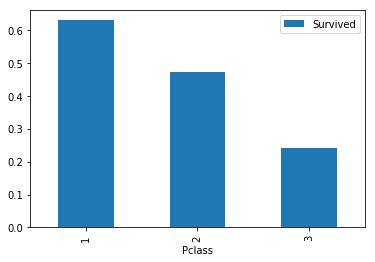

In [48]:
spark.sql("SELECT Pclass, count(Pclass) as class_count,\
         count(Pclass)*100/sum(count(Pclass)) over() AS percent \
         FROM titanic_table \
         WHERE Survived=1 GROUP BY Pclass").show()
import matplotlib.pyplot as plt
sex_table=train_pd.pivot_table(index="Pclass",values="Survived")
sex_table.plot.bar()
plt.show()

In [49]:
spark.sql("SELECT Age, count(Age) as age_count FROM titanic_table WHERE Survived == 1 GROUP BY Age ORDER BY age_count DESC").show()


+----+---------+
| Age|age_count|
+----+---------+
|24.0|       15|
|36.0|       11|
|22.0|       11|
|27.0|       11|
|35.0|       11|
|30.0|       10|
|19.0|        9|
|18.0|        9|
|32.0|        9|
|31.0|        8|
|29.0|        8|
| 4.0|        7|
|28.0|        7|
|17.0|        6|
|34.0|        6|
|25.0|        6|
|33.0|        6|
|48.0|        6|
|40.0|        6|
|42.0|        6|
+----+---------+
only showing top 20 rows



In [50]:
train_pd['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [51]:
#train.filter((train['Survived']==1)&(train['Age']>='14')).count()
train.filter((train['Survived']==1)&(train['Sex']=='female')&(train['Age']>=14)).count()
#train.filter((train['Survived']==1)&(train['Age']>='14')).count()

176

In [103]:
# fill in missing values
train_f = train.na.fill('00', subset=['Cabin'])
#train_f=train.na.fill('null',subset=['Age'])

#train_f.show()
from pyspark.sql.functions import mean
mean = train_f.select(mean(train['Age'])).collect()
mean_age = mean[0][0]
train_f = train_f.na.fill(mean_age,['Age'])
#train_f = train.na.fill('00', subset=['Cabin'])
train_f = train_f.withColumn("Age", func.round(train_f["Age"]).cast('integer'))
train_f = train_f.withColumn("Fare", func.round(train_f["Fare"]).cast('integer'))
train_f.show()

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+----+-----+--------+
|PassengerId|Embarked|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|Fare|Cabin|Survived|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+----+-----+--------+
|          1|       S|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7|   00|       0|
|          2|       C|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|  71|  C85|       1|
|          3|       S|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|   8|   00|       1|
|          4|       S|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|  53| C123|       1|
|          5|       S|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8|   00|       0|
|          6|       Q|     3|    Moran, Mr. James|  male| 30|    0|    0|          330877|   8|   00|       0|
|

In [104]:
from pyspark.ml.feature import (VectorAssembler,OneHotEncoder,
                                StringIndexer)

In [105]:
Sex_indexer=StringIndexer(inputCol='Sex',outputCol='SexIndex')
Sex_encoder=OneHotEncoder(inputCol='SexIndex',outputCol='SexVector')

Pclass_indexer=StringIndexer(inputCol='Pclass',outputCol='PclassIndex')
Pclass_encoder=OneHotEncoder(inputCol='PclassIndex',outputCol='PclassVector')

Age_indexer=StringIndexer(inputCol='Age',outputCol='AgeIndex')
Age_encoder=OneHotEncoder(inputCol='AgeIndex',outputCol='AgeVector')



Embarked_indexer=StringIndexer(inputCol='Embarked',outputCol='EmbarkedIndex')
Embarked_encoder=OneHotEncoder(inputCol='EmbarkedIndex',outputCol='EmbarkedVector')

Name_indexer=StringIndexer(inputCol='Name',outputCol='NameIndex')
Name_encoder=OneHotEncoder(inputCol='NameIndex',outputCol='NameVector')

Ticket_indexer=StringIndexer(inputCol='Ticket',outputCol='TicketIndex')
Ticket_encoder=OneHotEncoder(inputCol='TicketIndex',outputCol='TicketVector')
Fare_indexer=StringIndexer(inputCol='Fare',outputCol='FareIndex')
Fare_encoder=OneHotEncoder(inputCol='FareIndex',outputCol='FareVector')
Cabin_indexer=StringIndexer(inputCol='Cabin',outputCol='CabinIndex')
Cabin_encoder=OneHotEncoder(inputCol='CabinIndex',outputCol='CabinVector')
train_f.show()

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+----+-----+--------+
|PassengerId|Embarked|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|Fare|Cabin|Survived|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+----+-----+--------+
|          1|       S|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7|   00|       0|
|          2|       C|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|  71|  C85|       1|
|          3|       S|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|   8|   00|       1|
|          4|       S|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|  53| C123|       1|
|          5|       S|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8|   00|       0|
|          6|       Q|     3|    Moran, Mr. James|  male| 30|    0|    0|          330877|   8|   00|       0|
|

In [106]:
assembler=VectorAssembler(inputCols=['PassengerId','EmbarkedVector','PclassVector','NameVector','SexVector','AgeVector','SibSp','Parch','TicketVector','FareVector','CabinVector'],outputCol='features')

In [107]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='Survived',featuresCol='features')

In [108]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[Sex_indexer, Pclass_indexer, Age_indexer,Name_indexer,Embarked_indexer, Ticket_indexer,Fare_indexer, Cabin_indexer, Sex_encoder,
                           Pclass_encoder, Age_encoder,Name_encoder,Embarked_encoder,Ticket_encoder,Fare_encoder,Cabin_encoder, assembler, dtc])

In [112]:
train_data,test_data = train_f.randomSplit([0.7,0.3])#spliting train.csv into 70% for training and 30% for testing
train_f.show()
train_f.printSchema()

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+----+-----+--------+
|PassengerId|Embarked|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|Fare|Cabin|Survived|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+----+-----+--------+
|          1|       S|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7|   00|       0|
|          2|       C|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|  71|  C85|       1|
|          3|       S|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|   8|   00|       1|
|          4|       S|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|  53| C123|       1|
|          5|       S|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8|   00|       0|
|          6|       Q|     3|    Moran, Mr. James|  male| 30|    0|    0|          330877|   8|   00|       0|
|

In [113]:
model = pipeline.fit(train_data)#fitting the training model into the pipeline <3 
dtc_predictions = model.transform(test_data)#predicting the data B-)


Py4JJavaError: An error occurred while calling o4817.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 318.0 failed 1 times, most recent failure: Lost task 0.0 in stage 318.0 (TID 2690, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$9: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.Utils$.getIteratorSize(Utils.scala:1817)
	at org.apache.spark.rdd.RDD$$anonfun$count$1.apply(RDD.scala:1168)
	at org.apache.spark.rdd.RDD$$anonfun$count$1.apply(RDD.scala:1168)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:251)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:246)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:118)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:106)
	at org.apache.spark.ml.classification.DecisionTreeClassifier$$anonfun$train$1.apply(DecisionTreeClassifier.scala:121)
	at org.apache.spark.ml.classification.DecisionTreeClassifier$$anonfun$train$1.apply(DecisionTreeClassifier.scala:101)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:101)
	at org.apache.spark.ml.classification.DecisionTreeClassifier.train(DecisionTreeClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$9: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.Utils$.getIteratorSize(Utils.scala:1817)
	at org.apache.spark.rdd.RDD$$anonfun$count$1.apply(RDD.scala:1168)
	at org.apache.spark.rdd.RDD$$anonfun$count$1.apply(RDD.scala:1168)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:251)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:246)
	... 19 more


In [111]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

dtc_acc = acc_evaluator.evaluate(dtc_predictions)

print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

NameError: name 'dtc_predictions' is not defined